In [3]:
import numpy as np
import pandas as pd
from scipy.stats import trim_mean
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
sns.set()

from rliable import library as rly
from rliable import metrics
from rliable import plot_utils

In [25]:
# DreamerV3 
dreamerv3_data = pd.read_json("data/dmc_proprio-dreamerv3.json")
dreamerv3_data = dreamerv3_data[['task', 'ys']]
dreamerv3_data['episode_reward'] = dreamerv3_data['ys'].apply(lambda x: np.max(x))

# PPO
ppo_data = pd.read_json("data/dmc_proprio-ppo_fixhp.json")
ppo_data = ppo_data[['task', 'ys']]
ppo_data['episode_reward'] = ppo_data['ys'].apply(lambda x: np.max(x))

# SAC
sac_data = pd.read_csv("data/sac.csv")
# seperate unique run_id's into a list
run_ids = sac_data['run_id'].unique()
# create pandas dataframe to with columns "task" and "episode_reward"
temp = pd.DataFrame(columns=['task', 'episode_reward'])
for run_id in run_ids:
    # get all the data for the current run_id
    data = sac_data[sac_data['run_id'] == run_id]
    # get the task name
    task = data['env'].values[0]
    
    # get the episode reward
    episode_reward = data['episode_reward'].max()
    # add the task and episode reward to the temp dataframe
    temp = pd.concat([temp, pd.DataFrame({'task': [task], 'episode_reward': [episode_reward]})])
sac_data = temp

/tmp/ipykernel_74410/3692900274.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  temp = pd.concat([temp, pd.DataFrame({'task': [task], 'episode_reward': [episode_reward]})])


In [26]:
# Load data and process into metrics
pwm_data = pd.read_csv("data/fowm_mt30_h3_results.csv")

tdmpc_data = pd.read_csv("data/mt30_scores.csv")
tdmpc_data.index = tdmpc_data["Unnamed: 0"]
tdmpc_data = tdmpc_data.drop("Unnamed: 0", axis=1).T

# score dict is {algo: np.array num_exp x seeds x episode_rewards}
norm = 1000
score_dict = {"PWM": pwm_data.best_reward.values.astype(np.float32)[...,None][...,None]/norm,
             "PWM+planning": pwm_data.episode_reward_planning.values.astype(np.float32)[...,None][...,None]/norm,
             "TDMPC2": tdmpc_data.episode_reward.values.astype(np.float32)[..., None][..., None]/norm,
             "PPO": ppo_data.episode_reward.values.astype(np.float32)[..., None][..., None]/norm,
             "SAC": sac_data.episode_reward.values.astype(np.float32)[..., None][..., None]/norm,
             "DreamerV3": dreamerv3_data.episode_reward.values.astype(np.float32)[..., None][..., None]/norm,
            }

iqm = lambda scores: np.array([metrics.aggregate_iqm(scores[..., frame])
                               for frame in range(scores.shape[-1])])

tau = np.linspace(0.0, 1.0, 100)
reps = 2000
score_distributions, score_distributions_cis = rly.create_performance_profile(score_dict, tau, reps=reps)
iqm_scores, iqm_cis = rly.get_interval_estimates(score_dict, iqm, reps=reps)
mean_scores = {algo: np.mean(scores) for algo,scores in score_dict.items()} 


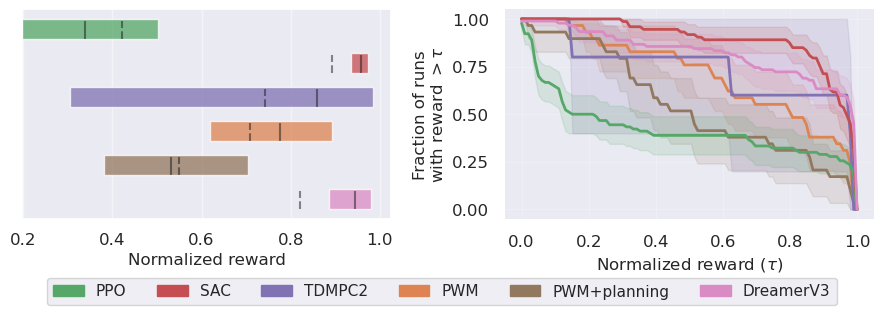

In [27]:
# Plot data
colors = sns.color_palette()

# baselines are PPO, SAC, TDMPC (no planning), TDMPC plannig, SHAC, FOWM
colors = {#"SHAC": colors[0],
         "PPO": colors[2],
         "SAC": colors[3],
         "TDMPC2": colors[4],
         "PWM": colors[1],
         "PWM+planning": colors[5],
         "DreamerV3": colors[6]}

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(9, 3))

# plot CI and median
h=0.6
labels = ["PPO", "SAC", "TDMPC2", "PWM", "PWM+planning", "DreamerV3"][::-1]
for idx, alg in enumerate(labels):
    ax1.barh(y=idx, width=iqm_cis[alg][1] - iqm_cis[alg][0], height=0.6, left=iqm_cis[alg][0], alpha=0.75, color=colors[alg])
    ax1.vlines(x=iqm_scores[alg],
        ymin=idx - (7.5 * h / 16),
        ymax=idx + (6.5 * h / 16),
        color='k',
        alpha=0.5)
    ax1.vlines(x=mean_scores[alg],
        ymin=idx - (7.5 * h / 16),
        ymax=idx + (6.5 * h / 16),
        color='k',
        alpha=0.5,
        linestyle="dashed",
        )

ax1.set_xlabel("Normalized reward")
ax1.grid(False)    
ax1.grid(True, axis='x', alpha=0.5)    
ax1.set_yticks([])
ax1.tick_params(axis='both', which='major', labelsize='medium')
# ax1.set_xlim((0.8, 1.47))

plot_utils.plot_performance_profiles(
  score_distributions, tau,
  performance_profile_cis=score_distributions_cis,
  colors=colors,
  xlabel=r'Normalized reward $(\tau)$',
  labelsize='medium',
  ax=ax2)
ax2.tick_params(axis='both', which='major', labelsize='medium', pad=1.3)
ax2.set_xlabel(r'Normalized reward $(\tau)$', fontsize='medium')
ax2.set_ylabel('Fraction of runs\nwith reward $> \\tau$', fontsize='medium')

# set legened helpers
fancy_legend = []
for k in colors.keys():
    patch = mpatches.Patch(color=colors[k], label=k)
    fancy_legend.append(patch)

plt.tight_layout()
fig.legend(handles=fancy_legend, loc='center', bbox_to_anchor=(0.5, 0.0), fancybox=True, shadow=False, ncol=len(fancy_legend))
plt.savefig("figures/mutlitask.pdf", bbox_inches="tight")